# Optiver Trading At The Close

[Competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close)

[GitHub Repository](https://github.com/cvaisnor/DNN-Final-Project)

[Google Slides Presentation](https://docs.google.com/presentation/d/1Xc5F1_NveFi1il3GqHej2aqVmklR_jZU4kx6ZJhiDEM/edit?usp=sharing)

# General Imports

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(kaggle_environment=False):
    '''Loads and returns the data files.'''
    if kaggle_environment:
        data_path = '/kaggle/input/'
    else:
        data_path = 'kaggle/input/'

    train = pd.read_csv(data_path + 'optiver-trading-at-the-close/train.csv')
    test = pd.read_csv(data_path + 'optiver-trading-at-the-close/example_test_files/test.csv')
    revealed_targets = pd.read_csv(data_path + 'optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
    sample_submission = pd.read_csv(data_path + 'optiver-trading-at-the-close/example_test_files/sample_submission.csv')

    return train, test, revealed_targets, sample_submission

def submit_dummy_predictions(env, predictions):
    '''Submits a dummy prediction to the Optiver API. Use when you have an error during processing
    of iter_test and you do not want to re-run the whole notebook to figure out if you fixed it.'''
    predictions["target"] = [0 for i in range(predictions.shape[0])]
    env.predict(predictions)

def plot_predictions(actuals, predicted):
    '''Plots actual vs predicted values to get a sense of whether the predictions make sense.'''

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


class LogFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for applying logarithmic transformation to specified columns.'''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            X[f'{column}_log'] = np.log1p(X[column].clip(lower=0.00001))
        return X

class CombineFeatures(BaseEstimator, TransformerMixin):
    '''Transformer to combine features by multiplication.'''
    def __init__(self, combined_features_list):
        self.combined_features_list = combined_features_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for combined_features in self.combined_features_list:
            combined_feature_name = '_'.join(combined_features)
            X[combined_feature_name] = X[combined_features].prod(axis=1)
        return X

class SubtractFeatures(BaseEstimator, TransformerMixin):
    """Transformer to subtract one feature from another."""

    def __init__(self, base_feature, feature_to_subtract):
        self.feature_to_subtract = feature_to_subtract
        self.base_feature = base_feature

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_feature_name = f"{self.base_feature}_minus_{self.feature_to_subtract}"
        X[new_feature_name] = X[self.base_feature] - X[self.feature_to_subtract]

        return X

class LagFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for creating lag features for specified columns and shift sizes.'''
    def __init__(self, features, shift_sizes, default_value):
        self.features = features
        self.shift_sizes = shift_sizes
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            for shift_size in self.shift_sizes:
                lag_col = f'{feature}_lag_{shift_size}'
                X[lag_col] = X.groupby(['stock_id', 'date_id'])[feature].shift(shift_size)
                X[lag_col].fillna(self.default_value, inplace=True)

        return X


class RollingMeanFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for calculating rolling mean of each feature over each specified window size.'''
    def __init__(self, features, window_sizes):
        self.features = features
        self.window_sizes = window_sizes

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rolling_mean_columns = []

        for feature in self.features:
            for window_size in self.window_sizes:
                rolling_mean_col = f'{feature}_rolling_mean{window_size}'
                rolling_mean_columns.append(rolling_mean_col)

                X[rolling_mean_col] = X.groupby(['stock_id', 'date_id'])[feature].rolling(window=window_size).mean().reset_index(level=[0,1], drop=True)

        for col in rolling_mean_columns:
            X[col].fillna(1.0, inplace=True)

        return X


class DiffFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for computing the difference of each feature column (i.e., first discrete difference).'''
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.features:
            diff_col = f'{feature}_diff'

            X[diff_col] = X.groupby(['stock_id', 'date_id'])[feature].diff()
            X[diff_col].fillna(0.0, inplace=True)

        return X


class ExpandingMeanFeatures(BaseEstimator, TransformerMixin):
    '''Transformer for calculating the expanding mean of each of the feature columns.'''
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        expanding_mean_columns = []

        for feature in self.features:
            expanding_mean_col = f'{feature}_expanding_mean'
            expanding_mean_columns.append(expanding_mean_col)

            X[expanding_mean_col] = X.groupby(['stock_id', 'date_id'])[feature].expanding().mean().reset_index(level=[0,1], drop=True)

        for col in expanding_mean_columns:
            X[col].fillna(1.0, inplace=True)

        return X

class DropColumns(BaseEstimator, TransformerMixin):
    '''Drops columns from the data frame.'''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        all_columns = X.columns
        drop_columns = []
        for column in self.columns:
            if column in all_columns:
                drop_columns.append(column)
        return X.drop(columns=drop_columns)

class ForwardFillValues(BaseEstimator, TransformerMixin):
    '''Transformer for forward filling NaN values in the DataFrame, grouped by stock_id.'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in X.columns:
            # X[column] = X.groupby(['stock_id', 'date_id'])[column].transform(lambda group: group.ffill())
            X[column] = X.groupby('stock_id')[column].transform(lambda group: group.ffill())
        return X


class FillZero(BaseEstimator, TransformerMixin):
    '''Transformer for replacing NaN values with zero in the DataFrame.'''
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.fillna(0.0)
        return X

class FillOne(BaseEstimator, TransformerMixin):
    '''Transformer for replacing NaN values with one in the DataFrame.'''
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.fillna(1.0)
        return X

class DataFrameWrapper(BaseEstimator, TransformerMixin):
    '''Wrapper for transforming output of a transformer to a DataFrame with optional specified columns.'''
    def __init__(self, transformer, columns=None):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        result = self.transformer.transform(X)
        if isinstance(result, pd.DataFrame):
            return result
        if self.columns is None:
            columns = X.columns
        else:
            columns = []
            for column in X.columns:
                if column in self.columns:
                    columns.append(column)
        return pd.DataFrame(result, columns=columns)

class PolynomialFeaturesWrapper(BaseEstimator, TransformerMixin):
    '''Transformer for generating polynomial and interaction features with specified degree.'''
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
        self.new_feature_names = None

    def fit(self, X, y=None):
        self.poly.fit(X)
        self.new_feature_names = self.poly.get_feature_names_out(X.columns)
        return self

    def transform(self, X):
        transformed_array = self.poly.transform(X)
        return pd.DataFrame(transformed_array, columns=self.new_feature_names)

class MissingValueImputer(BaseEstimator, TransformerMixin):
    '''Impute missing values in specified columns of a DataFrame using IterativeImputer.'''
    def __init__(self, columns, max_iter=10, random_state=0):
        self.columns = columns
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columns_to_impute = [col for col in self.columns if col in X.columns]

        # Select the columns for imputation
        columns_data = X[columns_to_impute]

        # Check if there are any missing values and if the columns are numeric
        if columns_data.isna().any().any() and columns_data.select_dtypes(include='number').shape[1] == len(columns_to_impute):
            imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)

            # Apply imputation
            imputed_data = imputer.fit_transform(columns_data)
            imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=X.index)

            # Update the original DataFrame
            X.update(imputed_df)
        return X


In [60]:
import os
import numpy as np
import pandas as pd
import importlib

# import helpers

kaggle_environment = False # True if running on Kaggle, don't forget to add the dataset!

# from helpers.common import load_data, plot_predictions, submit_dummy_predictions
# from helpers.pipeline import LogFeatures, LagFeatures, RollingMeanFeatures, DiffFeatures, ExpandingMeanFeatures, \
# ForwardFillValues, FillZero, DataFrameWrapper, PolynomialFeaturesWrapper, MissingValueImputer, DropColumns, FillOne

# if not kaggle_environment:
#     # Reload the modules
#     importlib.reload(helpers.common)
#     importlib.reload(helpers.pipeline)

# Loading Data

In [107]:
original_train, test, revealed_targets, sample_submission = load_data(kaggle_environment)

In [108]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(original_train) * split_ratio)

train = original_train.iloc[:split_idx]
test = original_train.iloc[split_idx:]

train = train.dropna(subset=['target', 'imbalance_size'])
test = test.dropna(subset=['target', 'imbalance_size'])

# train = train.dropna()
# test = test.dropna()

y = train['target'].values
y_test = test['target'].values

In [109]:
print(train.shape)
print(test.shape)

(4190274, 17)
(1047486, 17)


In [110]:
test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
4190384,4,385,420,9375764.34,1,1.001523,39592192.74,1.002241,1.002020,1.001413,5801.28,1.001634,181.33,1.001627,10.470152,21217,385_420_4
4190385,5,385,420,297718.61,1,1.006371,6720703.44,1.017943,1.007021,1.006111,26154.44,1.006371,79412.40,1.006175,-16.819836,21217,385_420_5
4190386,6,385,420,740319.79,-1,0.999097,13409310.36,0.980418,0.998220,0.998964,223708.10,0.999628,8653.29,0.999603,-2.580285,21217,385_420_6
4190387,7,385,420,0.00,0,1.001721,80638467.42,1.001721,1.001721,1.001296,22252.93,1.001799,4142.16,1.001720,-4.959702,21217,385_420_7
4190388,8,385,420,1607504.50,-1,1.000868,54598272.07,0.989186,1.000294,1.000755,269769.55,1.001571,143664.26,1.001288,-2.650022,21217,385_420_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


# Feature Engineering Section

In [111]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# drop_columns=['target', 'bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']
drop_columns=['target', 'time_id', 'row_id', 'currently_scored']
# drop_columns=['seconds_in_bucket', 'target', 'bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']

# Main Pipeline
pipeline = Pipeline([
    # ('logs', LogFeatures(['imbalance_size', 'matched_size', 'bid_size', 'ask_size'])),
    ('combine_features', CombineFeatures([
        ['imbalance_buy_sell_flag', 'reference_price', 'ask_price', 'bid_price'],
        ['imbalance_buy_sell_flag', 'far_price', 'near_price', 'ask_price'],
    ])),
    ('subtract_features', SubtractFeatures('ask_price', 'bid_price')),
    ('wap_lags', LagFeatures(['wap', 'imbalance_buy_sell_flag_reference_price_ask_price_bid_price', 'ask_price_minus_bid_price'], [1, 2], 1.0)),
    ('matched_size_lags', LagFeatures(['matched_size'], [1, 2], 0.0)),
    ('wap_rolling_means', RollingMeanFeatures(['wap'], [2])),
    ('diff_features', DiffFeatures(['wap', 'matched_size', 'ask_price', 'reference_price'])),
    # ('diff_features', DiffFeatures(['wap', 'imbalance_buy_sell_flag', 'matched_size', 'ask_price', 'reference_price'])),
    ('diff_features_2', DiffFeatures(['wap_diff', 'matched_size_diff', 'ask_price_diff', 'reference_price_diff'])),
    # ('diff_features_3', DiffFeatures(['wap_diff_diff', 'matched_size_diff_diff', 'ask_price_diff_diff', 'reference_price_diff_diff'])),
    ('wap_expanding_mean', ExpandingMeanFeatures(['wap'])),
    ('drop_columns', DropColumns(drop_columns)),
#     ('missing_value_imputer', MissingValueImputer(['far_price', 'near_price'])),
    # ('forward_fill', ForwardFillValues()),
    # ('fill_zero', FillZero()),
    # ('fill_one', FillOne()),
    # ('preprocessor', DataFrameWrapper(preprocessor, columns_to_keep)),
    ('drop_grouping_columns', DropColumns(['stock_id', 'date_id'])),
    # ('scaler', DataFrameWrapper(StandardScaler())),
    # ('poly', PolynomialFeaturesWrapper(2)),
])

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    train_transformed = pipeline.fit_transform(train)
    test_transformed = pipeline.transform(test)

CPU times: user 6.04 s, sys: 1.33 s, total: 7.37 s
Wall time: 7.55 s


In [112]:
X = train_transformed
X_test = test_transformed

In [116]:
len(X.columns)
# len(X_test.columns)

33

In [114]:
X_test.columns

Index(['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
       'reference_price', 'matched_size', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price',
       'imbalance_buy_sell_flag_far_price_near_price_ask_price',
       'ask_price_minus_bid_price', 'wap_lag_1', 'wap_lag_2',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price_lag_1',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price_lag_2',
       'ask_price_minus_bid_price_lag_1', 'ask_price_minus_bid_price_lag_2',
       'matched_size_lag_1', 'matched_size_lag_2', 'wap_rolling_mean2',
       'wap_diff', 'matched_size_diff', 'ask_price_diff',
       'reference_price_diff', 'wap_diff_diff', 'matched_size_diff_diff',
       'ask_price_diff_diff', 'reference_price_diff_diff',
       'wap_expanding_mean'],
      dtype='object')

In [115]:
X.columns

Index(['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
       'reference_price', 'matched_size', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price',
       'imbalance_buy_sell_flag_far_price_near_price_ask_price',
       'ask_price_minus_bid_price', 'wap_lag_1', 'wap_lag_2',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price_lag_1',
       'imbalance_buy_sell_flag_reference_price_ask_price_bid_price_lag_2',
       'ask_price_minus_bid_price_lag_1', 'ask_price_minus_bid_price_lag_2',
       'matched_size_lag_1', 'matched_size_lag_2', 'wap_rolling_mean2',
       'wap_diff', 'matched_size_diff', 'ask_price_diff',
       'reference_price_diff', 'wap_diff_diff', 'matched_size_diff_diff',
       'ask_price_diff_diff', 'reference_price_diff_diff',
       'wap_expanding_mean'],
      dtype='object')

In [98]:
# X['wap_lag_1']
# X[seconds_in_bucket]

All feature transformations should be combined into a generate_feature() function. This can then be applied to the test data will in the for loop for the Optiver API.

In [99]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)
    
    # Only return rows corresponding to the current test dataframe
    return transformed_df.iloc[-len(current_test):]


# Slicing

Generally, don't change the cell below. It is used to slice the data into training and validation sets.

In [119]:
# imports
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y 

# Model Development

In [133]:
%%time
import lightgbm as lgb


# lgbm = lgb.LGBMRegressor(n_jobs=-1, reg_lambda=0.2, random_state=0, num_leaves=650, boosting_type='gbdt', reg_alpha=0.2, objective='regression_l1')
lgbm = lgb.LGBMRegressor(n_jobs=-1, n_estimators=100, num_leaves=500, random_state=0, objective='regression_l1', reg_alpha=0.2)
lgbm.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7963
[LightGBM] [Info] Number of data points in the train set: 4190274, number of used features: 33
[LightGBM] [Info] Start training from score -0.069737
CPU times: user 1min 23s, sys: 19.2 s, total: 1min 42s
Wall time: 36.2 s


LGBMRegressor(n_jobs=-1, num_leaves=500, objective='regression_l1',
              random_state=0, reg_alpha=0.2)

In [134]:
from sklearn.metrics import mean_absolute_error

predictions = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on the test set: {mae:.4f}")

predictions2 = lgbm.predict(X_train)
mae2 = mean_absolute_error(y_train, predictions2)
print(f"Mean Absolute Error on the training set: {mae2:.4f}")

Mean Absolute Error on the test set: 5.9476
Mean Absolute Error on the training set: 6.2164


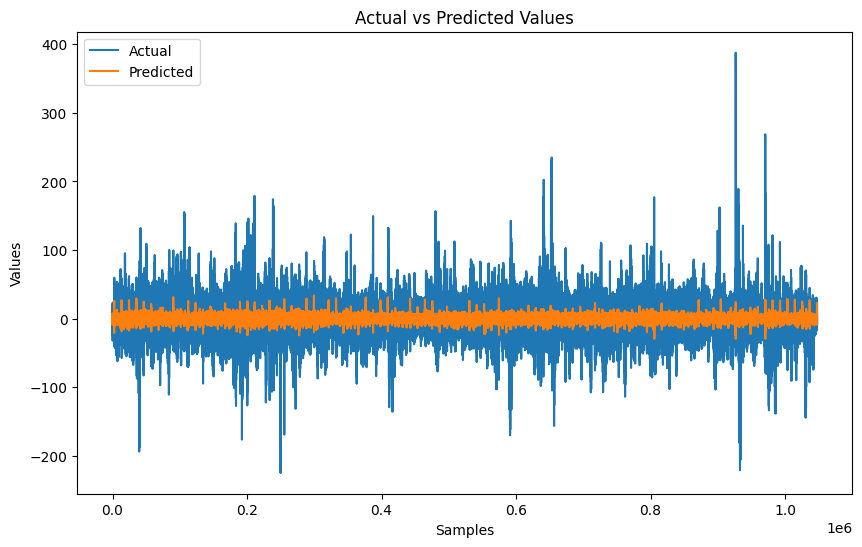

In [135]:
plot_predictions(y_test, predictions)

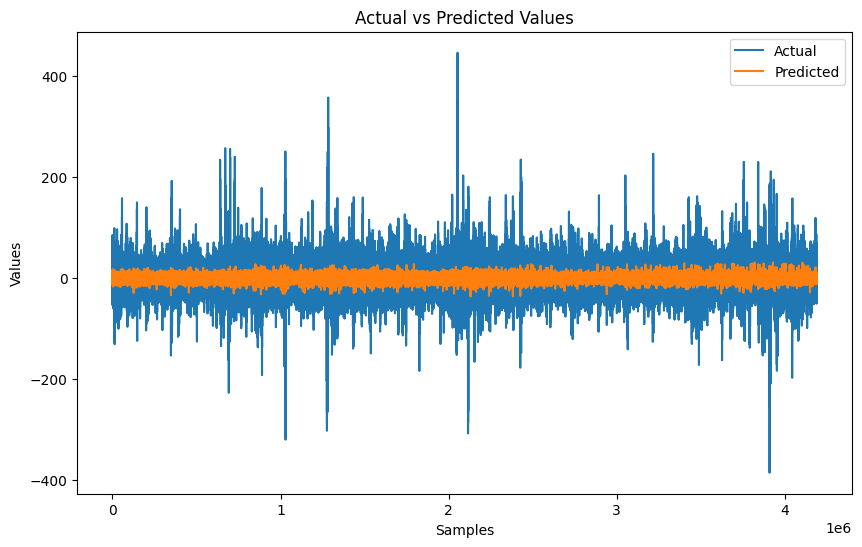

In [136]:
plot_predictions(y_train, predictions2)

In [137]:
print(predictions.min(), predictions.max())

-29.537421010414334 33.67310690561213


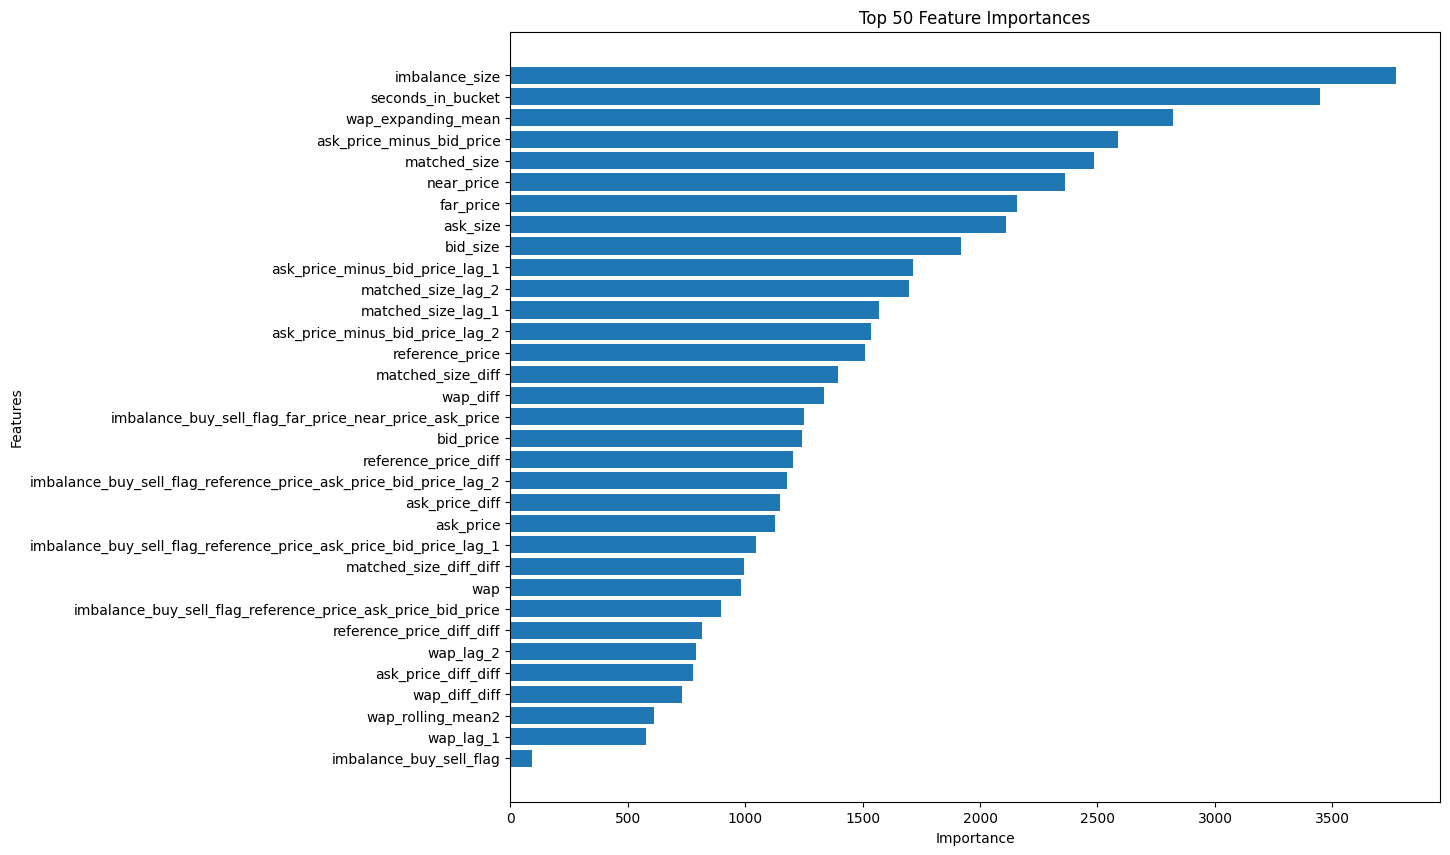

In [138]:
importances = lgbm.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)

top_50_features = sorted_features.head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [50]:
model = lgbm

# Generating Predictions

Only for Kaggle:
When uploading notebook, make sure to add the Optiver data on the right side of the screen.

In [51]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [52]:
# Uncomment this cell to try to get unstuck from having to restart and run the whole notebook again
# submit_dummy_predictions(env, sample_prediction)

In [53]:
# if kaggle_environment:
#     # To count how many time the "for loop" runs.
#     counter = 0

#     # init 3 empty lists
#     # test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
#     cumulative_test_df = pd.DataFrame()

#     for (test_in, revealed_targets, sample_prediction) in iter_test:
#         # Append the dataframe that API return into the list.
#         # test_ls.append(test_in.copy())
#         # revealed_targets_ls.append(revealed_targets.copy())
#         # sample_prediction_ls.append(sample_prediction.copy())

#         recent_rows = cumulative_test_df.tail(2000)
#         cumulative_test_df = pd.concat([recent_rows, test_in], axis=0, ignore_index=True)

#         # Generate features
#         test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

#         # Writes our predictions 
#         sample_prediction["target"] = model.predict(test_transformed)
        
#         # This line submit our predictions.
#         env.predict(sample_prediction)
#         counter += 1

#     print('\n', '=' * 50, sep="")
#     print(f"counter: {counter}")

In [54]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    # test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        # test_ls.append(test_in.copy())
        # revealed_targets_ls.append(revealed_targets.copy())
        # sample_prediction_ls.append(sample_prediction.copy())

        test_in['target'] = 0
        current_date_id = test_in.iloc[0]['date_id']
        cumulative_test_df = pd.concat([cumulative_test_df, test_in], axis=0, ignore_index=True)
#         if len(cumulative_test_df.columns) > 0:
        cumulative_test_df = cumulative_test_df[cumulative_test_df['date_id'] == current_date_id]
#             cumulative_test_df = pd.concat([current_date_rows, test_in], axis=0, ignore_index=True)
        print(f'{counter}: {cumulative_test_df.shape[0]}')

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

        # Writes our predictions 
        sample_prediction["target"] = model.predict(test_transformed)
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

In [55]:
# cumulative_test_df.to_csv('final_cumulative_2k_rows.csv')

In [56]:
y_test.var()

81.03471690678968